In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

import nibabel
import nibabel.processing
import os
from skimage.filters import threshold_otsu
import cc3d
import shutil
import pickle
import keras_tuner as kt
import random
from scipy import ndimage

In [2]:
#USE SMALL GPU#
use_gpu = 1
# The largest memory size GPU is always the first one (0) as they are sorted by size!
gpus=tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[use_gpu], 'GPU')

In [ ]:
#Here we load the dataset already preprocessed

In [ ]:
"""The confusion between g-dataset and b-dataset was eventually solved, g-dataset is the same as b, both contain 
only AD/CN, so the second part of this notebook (see old notebooks) is deleted. The first part shows the KT
optimization for AD/CN.

In [4]:
with open('gspec.pickle', 'rb') as f:
     spec = pickle.load(f)

In [5]:
train_loader=tf.data.experimental.load("./datasets/gtrain",element_spec=spec)
validation_loader=tf.data.experimental.load("./datasets/gval",element_spec=spec)
test_loader=tf.data.experimental.load("./datasets/gtest",element_spec=spec)

In [ ]:
#Define all the preprocessing functions for data augmentation and !!adding "color" dimension!! (important for keras)

In [6]:
@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

@tf.function
def shift(volume):
    def scipy_shift(volume):
        offsets = [-20, -10, -5, 5, 10, 20, 0]
        offset1 = random.choice(offsets)
        offset2 = random.choice(offsets)
        volume=ndimage.interpolation.shift(volume, (int(offset1), int(offset2), 0), order=5, mode='nearest')
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume
    augmented_volume = tf.numpy_function(scipy_shift, [volume], tf.float32)
    return augmented_volume

def train_preprocessing(volume, label):
    """Process training data by __Data_Aug__ and adding a channel."""
    volume = rotate(volume)
    volume = shift(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [ ]:
#Create a keras tuning hyperparameter object
hp=kt.HyperParameters()

In [7]:
batch_size = 8

# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(tf.data.experimental.cardinality(train_loader).numpy()).map(train_preprocessing).batch(batch_size).prefetch(2)
)
#Only add extra "color" dimension
validation_dataset = (
    validation_loader.map(validation_preprocessing).batch(batch_size).prefetch(2)
)

test_dataset= (
    test_loader.map(validation_preprocessing).batch(batch_size).prefetch(2)
)

Dimension of the scan is: (100, 100, 90, 1)


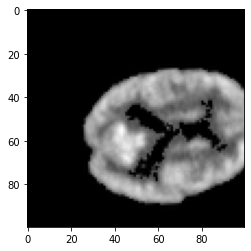

In [7]:
#This shows the output of the dataset loaders, turn on or off the imshow and the hist, move the axial slice number
data = train_dataset.take(3)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 50]), cmap="gray")
#plt.hist(np.ndarray.flatten(image))

In [ ]:
#We define a base model builder function (this is already the result of some previous tuning) to then tune

In [ ]:
def get_model(hp):
    """Build a 3D convolutional neural network model."""

    inputs = tf.keras.Input((100, 100, 90, 1))

    x = tf.keras.layers.Conv3D(filters=8, kernel_size=3, activation="relu")(inputs)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3D(filters=16, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Conv3D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    
    x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
        
    if hp.Boolean("fifth block"):
        x = tf.keras.layers.Conv3D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
        x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.4)(x)
        
        if hp.Boolean("sixth block"):
            x = tf.keras.layers.Conv3D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
            x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Dropout(0.4)(x)
                

    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    x = tf.keras.layers.Dense(units=512, activation="relu")(x)    

    outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = tf.keras.Model(inputs, outputs, name="3dcnn")
    
    lr = hp.Choice('lr', [0.0001, 0.001, 0.01])
    
    model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=["acc"])
    
    return model

In [ ]:
#When we build it we connect it to the hyperparameters variable
get_model(kt.HyperParameters())

#Input the name of the model to be trained, then tensorboard and modelcheckpoint adjust to it
print("Enter the name of the model: ")
x=input()

log_dir = "my_log_dir/{}".format(x)
modelpath=("saved_models/{0}".format(x))

callbacks = [
    #tf.keras.callbacks.ModelCheckpoint(
     #   filepath=os.path.join(modelpath,"epoch{epoch}"),
      #  save_best_only=True,  
      #  monitor="val_loss",
      #  verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=10),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                               histogram_freq=1,
                               embeddings_freq=1)]

In [ ]:
#Create the tuner

In [ ]:
tuner = kt.BayesianOptimization(
    hypermodel=get_model,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=2,
    overwrite=False,
    directory="keras_tuner",
    project_name="helloworld",
)


In [ ]:
#And perform the tuner search

In [ ]:
tuner.search(train_dataset,
            validation_data=validation_dataset,
            epochs=100,
            callbacks=[tf.keras.callbacks.TensorBoard("my_log_dir"), 
                       tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=10)])

In [ ]:
#This will show the best 10 models
tuner.results_summary()

In [ ]:
#And this will show the best hyperparameters
best_hps = tuner.get_best_hyperparameters(5)

In [ ]:
#With that information, we create a builder function with the best hyperparameters

In [8]:
def get_model(width=100, height=100, depth=90):
    """Build a 3D convolutional neural network model."""

    inputs = tf.keras.Input((100, 100, 90, 1))

    x = tf.keras.layers.Conv3D(filters=8, kernel_size=3, activation="relu")(inputs)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3D(filters=16, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Conv3D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    
    x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
        
    x = tf.keras.layers.Conv3D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    x = tf.keras.layers.Dense(units=512, activation="relu")(x)    

    outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model
    model = tf.keras.Model(inputs, outputs, name="3dcnn")
    return model

In [9]:
model=get_model()
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 90, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 98, 98, 88, 8)     224       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 49, 49, 44, 8)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 49, 49, 44, 8)     32        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 49, 49, 44, 16)    3472      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 24, 24, 22, 16)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 22, 16)    64    

In [10]:
metrics=['accuracy',tf.keras.metrics.Recall(),
         tf.keras.metrics.Precision(),
         tf.keras.metrics.AUC()]

In [11]:
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=metrics,
)

In [13]:
#Input the name of the model to be trained, then tensorboard and modelcheckpoint adjust to it
print("Enter the name of the model: ")
x=input()

log_dir = "my_log_dir/{}".format(x)
modelpath=("saved_models/{0}".format(x))

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(modelpath,"epoch{epoch}"),
        save_best_only=True,  
        monitor="val_loss",
        verbose=1),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                               histogram_freq=1,
                               embeddings_freq=1),
tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.000001),
tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]

Enter the name of the model: 
gender_went_wrong


In [ ]:
#And then train it with the best callbacks for peak performance when the training stops

In [15]:
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    shuffle=True,
    verbose=1,
    callbacks=callbacks,
)

Epoch 1/100
211/211 [==============================] - ETA: 0s - loss: 0.5849 - accuracy: 0.6865 - recall: 0.4746 - precision: 0.6235 - auc: 0.7347
Epoch 00001: val_loss improved from inf to 1.74956, saving model to saved_models/gender_went_wrong/epoch1
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_models/gender_went_wrong/epoch1/assets
211/211 [==============================] - 1891s 9s/step - loss: 0.5849 - accuracy: 0.6865 - recall: 0.4746 - precision: 0.6235 - auc: 0.7347 - val_loss: 1.7496 - val_accuracy: 0.3825 - val_recall: 1.0000 - val_precision: 0.3825 - val_auc: 0.5836
Epoch 2/100
211/211 [==============================] - ETA: 0s - loss: 0.5136 - accuracy: 0.7442 - recall: 0.6086 - precision: 0.6918 - auc: 0.8119
Epoch 00002: val_loss improved from 1

Epoch 16/100
211/211 [==============================] - ETA: 0s - loss: 0.4070 - accuracy: 0.8114 - recall: 0.7319 - precision: 0.7686 - auc: 0.8893
Epoch 00016: val_loss did not improve from 0.29726
211/211 [==============================] - 1877s 9s/step - loss: 0.4070 - accuracy: 0.8114 - recall: 0.7319 - precision: 0.7686 - auc: 0.8893 - val_loss: 0.3267 - val_accuracy: 0.8664 - val_recall: 0.7349 - val_precision: 0.8971 - val_auc: 0.9372
Epoch 17/100
211/211 [==============================] - ETA: 0s - loss: 0.4068 - accuracy: 0.8150 - recall: 0.7242 - precision: 0.7807 - auc: 0.8872
Epoch 00017: val_loss improved from 0.29726 to 0.29210, saving model to saved_models/gender_went_wrong/epoch17
INFO:tensorflow:Assets written to: saved_models/gender_went_wrong/epoch17/assets
211/211 [==============================] - 1845s 9s/step - loss: 0.4068 - accuracy: 0.8150 - recall: 0.7242 - precision: 0.7807 - auc: 0.8872 - val_loss: 0.2921 - val_accuracy: 0.8571 - val_recall: 0.7831 - val_p

In [ ]:
#Because the final model is usually a bit better than the last model checkpoint, we save it manually

In [17]:
model.save("saved_models/gender_went_wrong/finalmodel")

INFO:tensorflow:Assets written to: saved_models/gender_went_wrong/finalmodel/assets


In [ ]:
#Then we can load the checkpoint and compare their performance

In [10]:
checkmodel=tf.keras.models.load_model("")

In [11]:
checkmodel.evaluate(validation_dataset)

28/28 [==============================] - 1s 23ms/step - loss: 0.2921 - accuracy: 0.8571 - recall: 0.7831 - precision: 0.8333 - auc: 0.9452   


[0.29209765791893005,
 0.8571428656578064,
 0.7831325531005859,
 0.8333333134651184,
 0.9451537132263184]

In [12]:
checkmodel.evaluate(test_dataset)

27/27 [==============================] - 1s 23ms/step - loss: 0.3892 - accuracy: 0.7877 - recall: 0.7805 - precision: 0.7033 - auc: 0.9042    


[0.3891744911670685,
 0.7877358198165894,
 0.7804877758026123,
 0.7032967209815979,
 0.9042213559150696]